<a href="https://colab.research.google.com/github/mykon23/DL-2020Project/blob/effect_of_reg/Equus6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get the Equus Dataset

In [13]:
! wget -O Equus.tar.gz https://github.com/mykon23/DL-2020Project/blob/master/Equus.tar.gz?raw=true

--2020-04-23 17:12:04--  https://github.com/mykon23/DL-2020Project/blob/master/Equus.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mykon23/DL-2020Project/raw/master/Equus.tar.gz [following]
--2020-04-23 17:12:05--  https://github.com/mykon23/DL-2020Project/raw/master/Equus.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mykon23/DL-2020Project/master/Equus.tar.gz [following]
--2020-04-23 17:12:05--  https://raw.githubusercontent.com/mykon23/DL-2020Project/master/Equus.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting resp

In [0]:
! rm -rf Equus
! tar -zxf Equus.tar.gz

In [0]:
! rm *.tar.gz
! rm -rf train/
! rm -rf validation/
! rm -rf test/

Create the Training Set, Validation Set, and Test Set

In [0]:
import os

##Creates the folder structure of the data staging locations
def set_dataset_loc(loc, sub_dirs):
  if not os.path.exists(loc):
    os.mkdir(loc)
    for s in sub_dirs:
      os.mkdir(os.path.join(loc, s))


dataset_dir = os.path.join('.', 'Equus')
lst_members = os.listdir(dataset_dir)

set_dataset_loc(os.path.join('.', 'train'), lst_members)
set_dataset_loc(os.path.join('.', 'validation'), lst_members)
set_dataset_loc(os.path.join('.', 'test'), lst_members)


In [17]:
##Display distribution of data

for d in os.listdir(dataset_dir):
  print(f'{d}: {len(os.listdir(os.path.join(dataset_dir, d)))}')

Zebra: 339
Horse: 314
Donkey: 391


In [18]:
!ls -lh

total 7.2M
-rw-r--r-- 1 root root 7.2M Apr 23 17:09 4ConvMaxPool3DenseBaseline.h5
drwxr-xr-x 5 root root 4.0K Mar 16 03:00 Equus
drwxr-xr-x 1 root root 4.0K Apr  3 16:24 sample_data
drwxr-xr-x 5 root root 4.0K Apr 23 17:12 test
drwxr-xr-x 5 root root 4.0K Apr 23 17:12 train
drwxr-xr-x 5 root root 4.0K Apr 23 17:12 validation


In [0]:
import shutil

##Populate the staging locations for the data
def stage_data_loc(stage_loc, data_loc, dict_ind):

  ##Create a dictionary containing the images
  dict_images = { k : os.listdir(os.path.join(data_loc, k)) for k in lst_members }

  for k in dict_images.keys():
    for i in range(dict_ind[k][0], dict_ind[k][1]):
      src = os.path.join(os.path.join(data_loc, k), dict_images[k][i])
      dst = os.path.join(os.path.join(stage_loc, k), dict_images[k][i])
      shutil.copyfile(src, dst)

##Keep indices for the data splits
dict_train = {'Donkey': [0, 240], 'Horse': [0, 185], 'Zebra':[0, 185]}
dict_val = {'Donkey': [240, 315], 'Horse': [185, 250], 'Zebra':[185, 249]}
dict_test = {'Donkey': [315, 391], 'Horse': [250, 314],'Zebra': [249, 339]}

stage_data_loc(os.path.join('.', 'train'), dataset_dir, dict_train)
stage_data_loc(os.path.join('.', 'validation'), dataset_dir, dict_val)
stage_data_loc(os.path.join('.', 'test'), dataset_dir, dict_test)


In [20]:
##Count the number of files within each directory
! ls -lh train/*/* | wc -l
! ls -lh validation/*/* | wc -l
! ls -lh test/*/* | wc -l

610
204
230


Define Train and Test Operations

In [0]:
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

def train_model(model, train, val, model_path):
  ##Set the callbacks
  callback_list = [
  tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    ),
  tf.keras.callbacks.ModelCheckpoint(
      filepath=model_path,
      monitor='val_loss',
      save_best_only=True,
    )
  ]

  ##Train the model
  history = model.fit(
      train['gen'],
      steps_per_epoch=train['steps'],
      epochs=50,
      callbacks = callback_list,
      validation_data=val['gen'],
      validation_steps=val['steps'])
  
  return history

def disp_plot(history, title):
  plt.figure()
  plt.plot(history.history['accuracy'], 'bo', label='Training Acc')
  plt.plot(history.history['val_accuracy'], 'b', label='Validation Acc')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(history.history['loss'], 'bo', label='Training Loss')
  plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.legend()
  plt.show()

def test_model(model, test):
  ##Observe the results of the model against the test data
  test_loss, test_acc = model.evaluate(
    test['gen'],
    steps=test['steps']
  )
  
  return {'accuracy': test_acc, 'loss': test_loss }


Establish Baseline Data Generators

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('.', 'train')
val_dir = os.path.join('.', 'validation')
test_dir = os.path.join('.', 'test')

train_batches = 61
val_batches = 17
test_batches = 23

##Create Development Set Generators
##Note that 61 * 10 = 610 training samples
train_generator = ImageDataGenerator(rescale=1./255,
                                     ).flow_from_directory(train_dir, target_size=(256, 256), batch_size=10, class_mode='categorical')
##Note that 17 * 12 = 240 validation samples
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(256, 256), batch_size=12, class_mode='categorical')

##Create Test Generator
##Note that 23 * 10 = 230 Test samples
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(256,256), batch_size=10, class_mode='categorical')

Found 610 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 230 images belonging to 3 classes.


Observe Benchmark with no Regularization

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)       

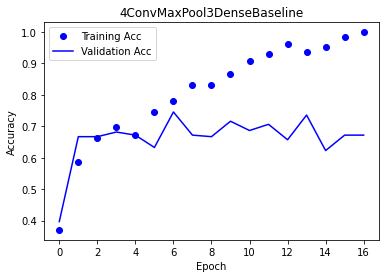

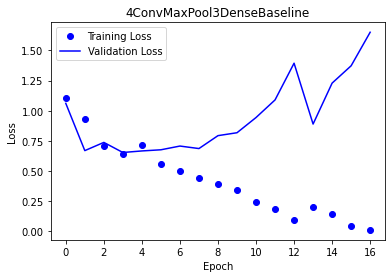

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseBaseline.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [24]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 19ms/step - loss: 0.6417 - accuracy: 0.7043
Test: {'accuracy': 0.7043478488922119, 'loss': 0.6416650414466858}
17/17 [==============================] - 0s 24ms/step - loss: 0.6281 - accuracy: 0.7010
Val: {'accuracy': 0.7009803652763367, 'loss': 0.6281099319458008}
61/61 [==============================] - 1s 20ms/step - loss: 0.5786 - accuracy: 0.7197
Train: {'accuracy': 0.7196721434593201, 'loss': 0.5786073207855225}


Observe L1 Regularization

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)       

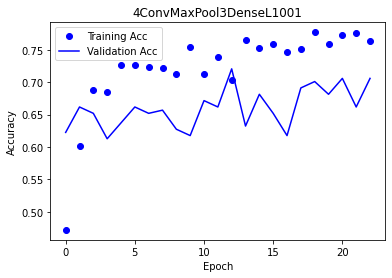

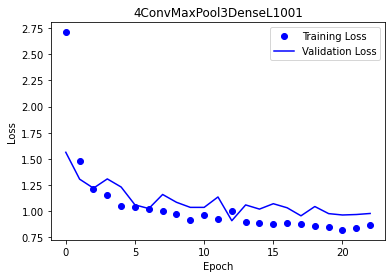

In [25]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l1=0.001)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL1001.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [26]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 1.0212 - accuracy: 0.6957
Test: {'accuracy': 0.695652186870575, 'loss': 1.0212208032608032}
17/17 [==============================] - 0s 24ms/step - loss: 0.9814 - accuracy: 0.6912
Val: {'accuracy': 0.6911764740943909, 'loss': 0.9813768863677979}
61/61 [==============================] - 1s 21ms/step - loss: 0.8960 - accuracy: 0.7295
Train: {'accuracy': 0.7295082211494446, 'loss': 0.8959696292877197}


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)       

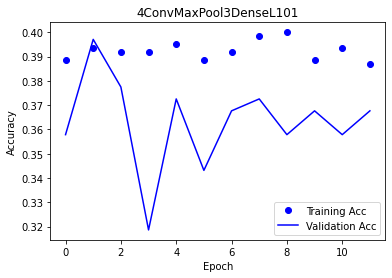

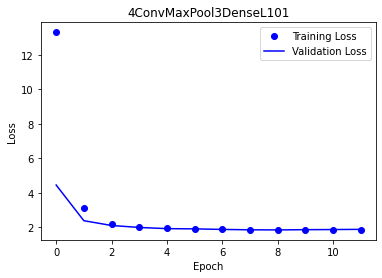

In [27]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l1=0.01)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL101.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [28]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 1.8568 - accuracy: 0.3261
Test: {'accuracy': 0.32608696818351746, 'loss': 1.8567962646484375}
17/17 [==============================] - 0s 23ms/step - loss: 1.8493 - accuracy: 0.3676
Val: {'accuracy': 0.36764705181121826, 'loss': 1.8492685556411743}
61/61 [==============================] - 1s 20ms/step - loss: 1.8396 - accuracy: 0.4197
Train: {'accuracy': 0.4196721315383911, 'loss': 1.839585781097412}


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 32)       

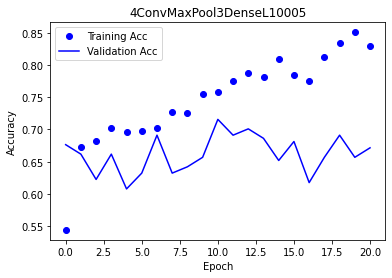

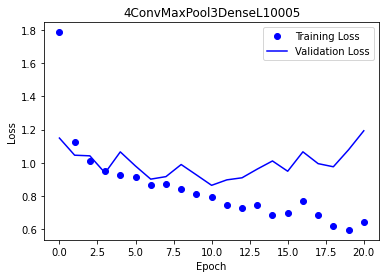

In [29]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l1=0.0005)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL10005.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [30]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 21ms/step - loss: 0.8855 - accuracy: 0.7130
Test: {'accuracy': 0.7130434513092041, 'loss': 0.885475218296051}
17/17 [==============================] - 0s 24ms/step - loss: 0.8275 - accuracy: 0.7255
Val: {'accuracy': 0.7254902124404907, 'loss': 0.8274922370910645}
61/61 [==============================] - 1s 20ms/step - loss: 0.7356 - accuracy: 0.8230
Train: {'accuracy': 0.8229508399963379, 'loss': 0.7356200814247131}


Observe L2 Regularization

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 32)       

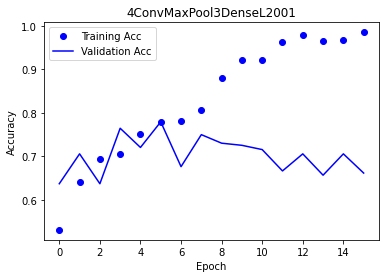

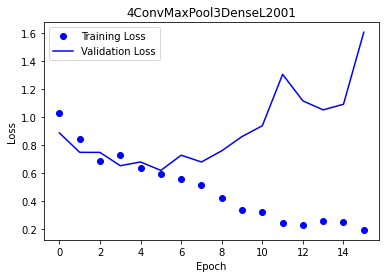

In [31]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l2=0.001)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL2001.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [32]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.6123 - accuracy: 0.7652
Test: {'accuracy': 0.7652173638343811, 'loss': 0.6122855544090271}
17/17 [==============================] - 0s 23ms/step - loss: 0.6519 - accuracy: 0.7549
Val: {'accuracy': 0.7549019455909729, 'loss': 0.6518561840057373}
61/61 [==============================] - 1s 20ms/step - loss: 0.5159 - accuracy: 0.8197
Train: {'accuracy': 0.8196721076965332, 'loss': 0.5158559083938599}


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 32)       

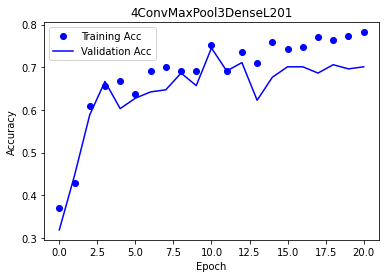

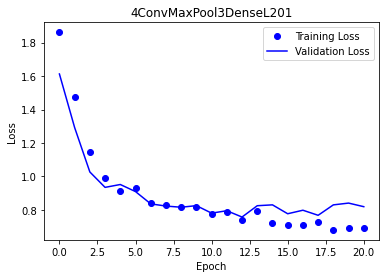

In [33]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l2=0.01)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL201.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [34]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.8716 - accuracy: 0.6652
Test: {'accuracy': 0.665217399597168, 'loss': 0.8715843558311462}
17/17 [==============================] - 0s 23ms/step - loss: 0.7766 - accuracy: 0.7010
Val: {'accuracy': 0.7009803652763367, 'loss': 0.7766352891921997}
61/61 [==============================] - 1s 21ms/step - loss: 0.7043 - accuracy: 0.7689
Train: {'accuracy': 0.7688524723052979, 'loss': 0.7042587399482727}


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 32)       

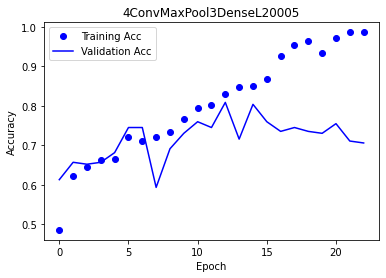

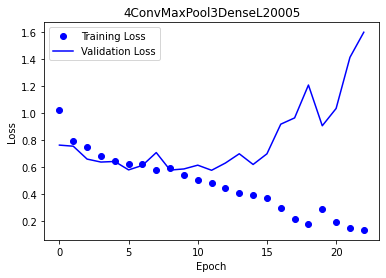

In [35]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l2=0.0005)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL20005.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [36]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 19ms/step - loss: 0.6147 - accuracy: 0.7739
Test: {'accuracy': 0.7739130258560181, 'loss': 0.6146923303604126}
17/17 [==============================] - 0s 23ms/step - loss: 0.5930 - accuracy: 0.7353
Val: {'accuracy': 0.7352941036224365, 'loss': 0.5929617881774902}
61/61 [==============================] - 1s 20ms/step - loss: 0.4197 - accuracy: 0.8525
Train: {'accuracy': 0.8524590134620667, 'loss': 0.4197041690349579}


Observe Dropout

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 28, 28, 32)       

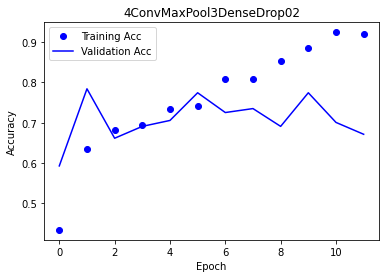

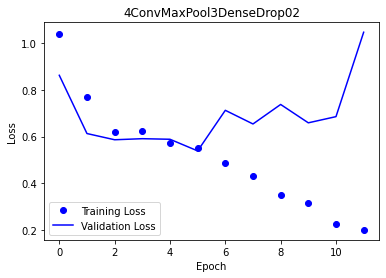

In [37]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dropout(0.2) )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseDrop02.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [38]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.4784 - accuracy: 0.7609
Test: {'accuracy': 0.760869562625885, 'loss': 0.47838112711906433}
17/17 [==============================] - 0s 24ms/step - loss: 0.5589 - accuracy: 0.7745
Val: {'accuracy': 0.7745097875595093, 'loss': 0.5588868260383606}
61/61 [==============================] - 1s 22ms/step - loss: 0.4410 - accuracy: 0.8049
Train: {'accuracy': 0.8049180507659912, 'loss': 0.4410160481929779}


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 28, 32)      

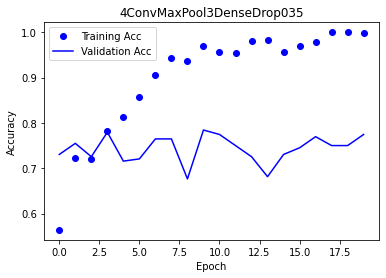

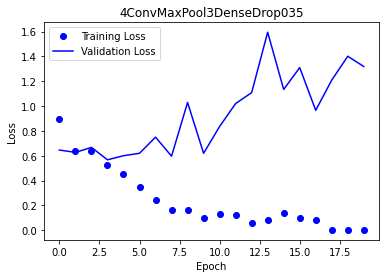

In [39]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dropout(0.35) )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseDrop035.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [40]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.5321 - accuracy: 0.7565
Test: {'accuracy': 0.7565217614173889, 'loss': 0.5320630073547363}
17/17 [==============================] - 0s 23ms/step - loss: 0.5482 - accuracy: 0.7843
Val: {'accuracy': 0.7843137383460999, 'loss': 0.5481605529785156}
61/61 [==============================] - 1s 21ms/step - loss: 0.4137 - accuracy: 0.8443
Train: {'accuracy': 0.8442623019218445, 'loss': 0.41372260451316833}


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 28, 28, 32)      

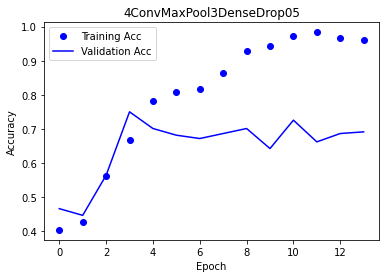

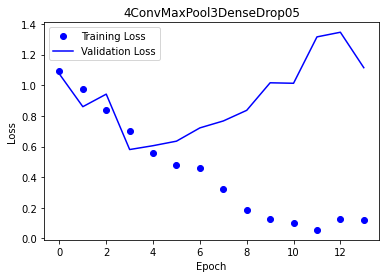

In [41]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dropout(0.5) )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseDrop05.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [42]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 21ms/step - loss: 0.5975 - accuracy: 0.6870
Test: {'accuracy': 0.686956524848938, 'loss': 0.5975448489189148}
17/17 [==============================] - 0s 24ms/step - loss: 0.6081 - accuracy: 0.7353
Val: {'accuracy': 0.7352941036224365, 'loss': 0.6081289649009705}
61/61 [==============================] - 1s 21ms/step - loss: 0.5892 - accuracy: 0.7443
Train: {'accuracy': 0.7442622780799866, 'loss': 0.5891802906990051}


Observe Batch Normalization

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
batch_normalization_4 (Batch (None, 254, 254, 12)      48        
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
batch_normalization_5 (Batch (None, 125, 125, 12)      48        
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 60, 60, 32)      

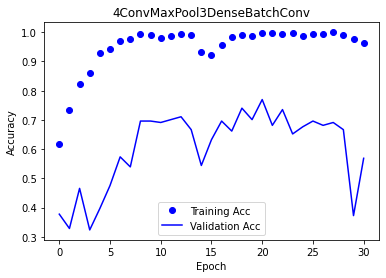

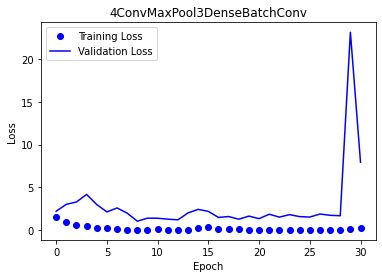

In [43]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( BatchNormalization())
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( BatchNormalization())
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( BatchNormalization())
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( BatchNormalization())
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseBatchConv.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [44]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 1.2890 - accuracy: 0.6957
Test: {'accuracy': 0.695652186870575, 'loss': 1.2889896631240845}
17/17 [==============================] - 0s 23ms/step - loss: 1.2214 - accuracy: 0.6716
Val: {'accuracy': 0.6715686321258545, 'loss': 1.221380591392517}
61/61 [==============================] - 1s 21ms/step - loss: 0.1060 - accuracy: 0.9607
Train: {'accuracy': 0.9606557488441467, 'loss': 0.10599090903997421}


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 28, 28, 32)      

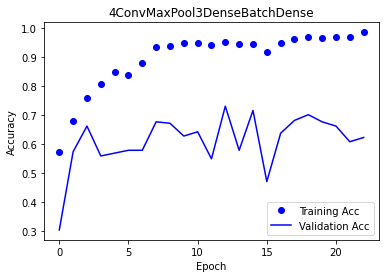

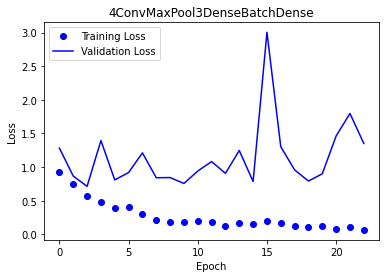

In [45]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( BatchNormalization())
model.add( Dense( 12, activation = 'relu' ) )
model.add( BatchNormalization())
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseBatchDense.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [46]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 21ms/step - loss: 0.8349 - accuracy: 0.5826
Test: {'accuracy': 0.582608699798584, 'loss': 0.8349408507347107}
17/17 [==============================] - 0s 24ms/step - loss: 0.7144 - accuracy: 0.6716
Val: {'accuracy': 0.6715686321258545, 'loss': 0.7144157886505127}
61/61 [==============================] - 1s 21ms/step - loss: 0.5334 - accuracy: 0.7672
Train: {'accuracy': 0.7672131061553955, 'loss': 0.53335040807724}


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
batch_normalization_10 (Batc (None, 254, 254, 12)      48        
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
batch_normalization_11 (Batc (None, 125, 125, 12)      48        
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 60, 60, 32)      

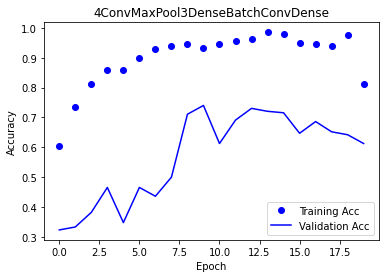

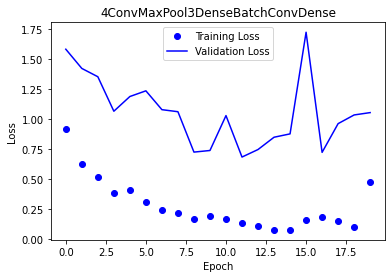

In [47]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( BatchNormalization())
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( BatchNormalization())
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( BatchNormalization())
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( BatchNormalization())
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( BatchNormalization())
model.add( Dense( 12, activation = 'relu' ) )
model.add( BatchNormalization())
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseBatchConvDense.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [48]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 22ms/step - loss: 0.5232 - accuracy: 0.7913
Test: {'accuracy': 0.791304349899292, 'loss': 0.5231835246086121}
17/17 [==============================] - 0s 25ms/step - loss: 0.7189 - accuracy: 0.6618
Val: {'accuracy': 0.6617646813392639, 'loss': 0.7188584208488464}
61/61 [==============================] - 1s 21ms/step - loss: 0.0343 - accuracy: 0.9967
Train: {'accuracy': 0.9967213273048401, 'loss': 0.03427206352353096}
